In [15]:
%matplotlib inline
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
tf.set_random_seed(0)

In [75]:
import matplotlib.pyplot as plt
import math

In [2]:
mnist = read_data_sets("data", one_hot=True, reshape=False, validation_size=0)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [3]:
X = tf.placeholder(tf.float32, [None, 28, 28, 1])

In [4]:
Y_ = tf.placeholder(tf.float32, [None, 10])

# Standard nerural net setup

In [5]:
# W1 = tf.Variable(tf.truncated_normal([28*28, 500], stddev=0.1))
# B1 = tf.Variable(tf.ones([500])/10)

# W2 = tf.Variable(tf.truncated_normal([500, 500], stddev=0.1))
# B2 = tf.Variable(tf.ones([500])/10)

# W3 = tf.Variable(tf.truncated_normal([500, 500], stddev=0.1))
# B3 = tf.Variable(tf.ones([500])/10)

# W4 = tf.Variable(tf.truncated_normal([500, 500], stddev=0.1))
# B4 = tf.Variable(tf.ones([500])/10)

# W5 = tf.Variable(tf.truncated_normal([500, 10], stddev=0.1))
# B5 = tf.Variable(tf.ones([10])/10)

In [6]:
# XX = tf.reshape(X, [-1, 784])

In [7]:
# Y1 = tf.nn.relu(tf.matmul(XX, W1) + B1)
# Y2 = tf.nn.relu(tf.matmul(Y1, W2) + B2)
# Y3 = tf.nn.relu(tf.matmul(Y2, W3) + B3)
# Y4 = tf.nn.relu(tf.matmul(Y3, W4) + B4)
# Ylogits = tf.matmul(Y4, W5) + B5
# Y  = tf.nn.softmax(Ylogits)

# CNN setup

In [65]:
W1 = tf.Variable(tf.truncated_normal([5, 5, 1, 6], stddev=0.1))
B1 = tf.Variable(tf.ones([6])/10)

W2 = tf.Variable(tf.truncated_normal([4, 4, 6, 12], stddev=0.1))
B2 = tf.Variable(tf.ones([12])/10)

W3 = tf.Variable(tf.truncated_normal([4, 4, 12, 24], stddev=0.1))
B3 = tf.Variable(tf.ones([24])/10)

W4 = tf.Variable(tf.truncated_normal([7*7*24, 200], stddev=0.1))
B4 = tf.Variable(tf.ones([200])/10)

W5 = tf.Variable(tf.truncated_normal([200, 10], stddev=0.1))
B5 = tf.Variable(tf.ones([10])/10)

In [66]:
pkeep = tf.placeholder(tf.float32)

stride = 1  # output is still 28x28
Ycnv1 = tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME')
Y1 = tf.nn.relu(Ycnv1 + B1)

stride2 = 2  # output is now 14x14
Ycnv2 = tf.nn.conv2d(Y1, W2, strides=[1, stride2, stride2, 1], padding='SAME')
Y2 = tf.nn.relu(Ycnv2 + B2)

stride3 = 2  # output is now 14x14
Ycnv3 = tf.nn.conv2d(Y2, W3, strides=[1, stride3, stride3, 1], padding='SAME')
Y3 = tf.nn.relu(Ycnv3 + B3)

XXX = tf.reshape(Y3, [-1, 7*7*24])

Y4 = tf.nn.relu(tf.matmul(XXX, W4) + B4)
Y4d = tf.nn.dropout(Y4, pkeep)

Ylogits = tf.matmul(Y4d, W5) + B5
Y  = tf.nn.softmax(Ylogits)

# Cost and training

In [67]:
# cross_entropy = -tf.reduce_mean(Y_ * tf.log(Y)) * 1000.0 
cross_entropy = tf.nn.softmax_cross_entropy_with_logits( logits=Ylogits,labels= Y_)
cross_entropy = tf.reduce_mean(cross_entropy)*100

In [68]:
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [69]:
lrate = tf.placeholder(tf.float32)
train_step = tf.train.AdamOptimizer(lrate).minimize(cross_entropy)

In [70]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [76]:
lrmin = 0.0001
lrmax = 0.003

def training_step(i, update_test_data, update_train_data):

    # training on batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)

    if update_train_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={X: batch_X, Y_: batch_Y, pkeep:1.0})
        print(str(i) + ": accuracy:" + str(a) + " loss: " + str(c))
        train_score_log.append((i,a))
    if update_test_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={X: mnist.test.images, Y_: mnist.test.labels, pkeep:1.0})
        print(str(i) + ": ********* epoch " + str(i*100//mnist.train.images.shape[0]+1) + " ********* test accuracy:" + str(a) + " test loss: " + str(c))
        test_score_log.append( (i,a) )
    
    # learning rate decay
    lr = lrmin+(lrmax-lrmin)*math.exp(-i/4000)
        
    # the backpropagation training step
    sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y, pkeep:0.75, lrate:lr})

In [ ]:
train_score_log = []
test_score_log = []

In [80]:
for i in range(4000,8000): 
    training_step(i, i % 50 == 0, i % 10 == 0)

4000: accuracy:1.0 loss: 0.00328583
4000: ********* epoch 7 ********* test accuracy:0.9911 test loss: 4.51701
4010: accuracy:1.0 loss: 0.000955417
4020: accuracy:1.0 loss: 0.0365593
4030: accuracy:1.0 loss: 6.67571e-06
4040: accuracy:1.0 loss: 0.000274032
4050: accuracy:1.0 loss: 0.00177353
4050: ********* epoch 7 ********* test accuracy:0.9906 test loss: 4.89443
4060: accuracy:1.0 loss: 0.0190895
4070: accuracy:1.0 loss: 0.0134299
4080: accuracy:1.0 loss: 0.00851619
4090: accuracy:0.99 loss: 1.85735
4100: accuracy:1.0 loss: 0.221484
4100: ********* epoch 7 ********* test accuracy:0.9908 test loss: 4.55488
4110: accuracy:1.0 loss: 0.0164696
4120: accuracy:1.0 loss: 0.0253809
4130: accuracy:1.0 loss: 0.000358081
4140: accuracy:1.0 loss: 0.049333
4150: accuracy:1.0 loss: 0.00275756
4150: ********* epoch 7 ********* test accuracy:0.9896 test loss: 5.30621
4160: accuracy:1.0 loss: 0.0282388
4170: accuracy:1.0 loss: 0.000391225
4180: accuracy:1.0 loss: 0.305573
4190: accuracy:0.99 loss: 0.9

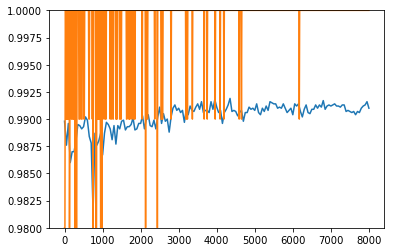

In [81]:
plt.plot(list(zip(*test_score_log))[0],list(zip(*test_score_log))[1])
plt.plot(list(zip(*train_score_log))[0],list(zip(*train_score_log))[1])
plt.ylim(0.98,1)
plt.show()

In [82]:
sorted(list(zip(*test_score_log))[1])[-1]

0.99190003